In [32]:
### I have been using features from layer1, layer2, layer3, layer4, final layer
### Let's try with the individual conv layers e.g. layer2.0.conv1
### Cadena et al. use sublayers for VGG-19 https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006897#sec002

In [33]:
import numpy as np
from os import path
import matplotlib.pyplot as plt

### 1.1. Load data

# imresps.npy is of shape (1573, 2, 15363), where 1573 is number of images, 2 repeats each, and 15363 neurons recorded
# stimids.npy has the image id (matching the image dataset ~selection1866~) for each stimulus number, 
# so of you want to see what image was presented on imresps[502] you would check stim_ids[502]

PATH_TO_DATA = '../../data/neural'

imresps = np.load(path.join(PATH_TO_DATA, 'imresps.npy'))
stimids = np.load(path.join(PATH_TO_DATA, 'stimids.npy'))

print(imresps.shape) # (1573, 2, 15363)
print(stimids.shape) # (1573,)

(1573, 2, 15363)
(1573,)


[ 0.00545773 -0.03046174 -0.00557603 ... -0.04588348 -0.0120997
  0.01764563]
[-0.03683467 -0.01403668 -0.0186997  ... -0.0143124  -0.0085368
 -0.00041092]


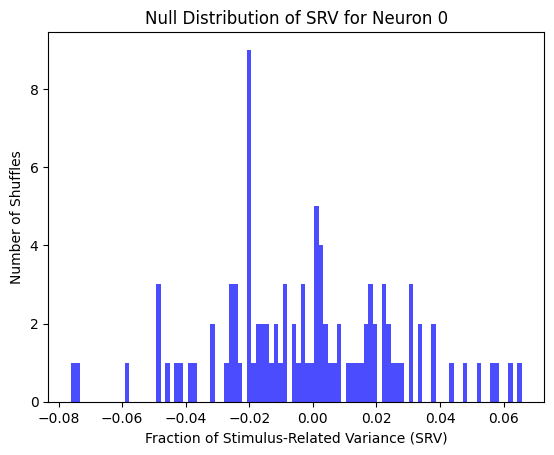

[-0.02786713 -0.00768085 -0.03650273 ...  0.20557109  0.03143906
  0.02287268]
[-0.02711161 -0.00762231 -0.03521721 ...  0.25876587  0.03245955
  0.02340808]
Real SRV shape: (15363,)


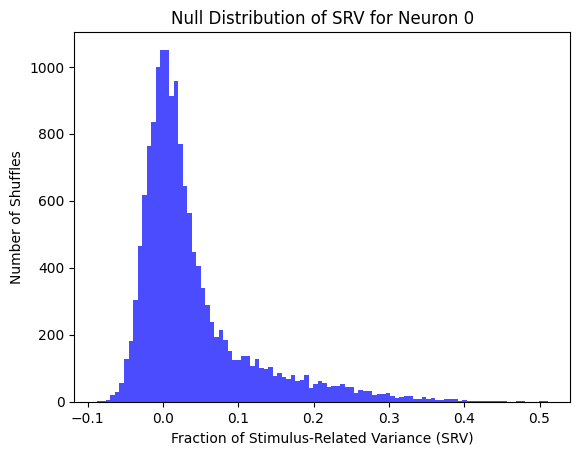

[0.06260926 0.06981875 0.05497216 ... 0.05592131 0.06616617 0.08254829]
Number of reliable neurons: 3698
Indices of reliable neurons: [   14    70    71 ... 15356 15358 15360]


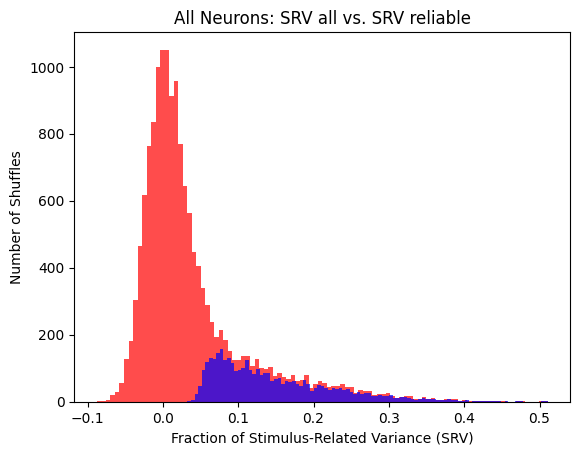

In [34]:
### 2.1. Compute the null distribution of SRV values for all neurons

def compute_signal_related_variance(resp_a, resp_b, mean_center=True):
    """
    compute the fraction of signal-related variance for each neuron,
    as per Stringer et al Nature 2019. Cross-validated by splitting
    responses into two halves. Note, this only is "correct" if resp_a
    and resp_b are *not* averages of many trials.

    Args:
        resp_a (ndarray): n_stimuli, n_cells
        resp_b (ndarray): n_stimuli, n_cells

    Returns:
        fraction_of_stimulus_variance: 0-1, 0 is non-stimulus-caring, 1 is only-stimulus-caring neurons
        stim_to_noise_ratio: ratio of the stim-related variance to all other variance
    """
    if len(resp_a.shape) > 2:
        # if the stimulus is multi-dimensional, flatten across all stimuli
        resp_a = resp_a.reshape(-1, resp_a.shape[-1])
        resp_b = resp_b.reshape(-1, resp_b.shape[-1])
    ns, nc = resp_a.shape
    if mean_center:
        # mean-center the activity of each cell
        resp_a = resp_a - resp_a.mean(axis=0)
        resp_b = resp_b - resp_b.mean(axis=0)
    
    # compute the cross-trial stimulus covariance of each cell
    # dot-product each cell's (n_stim, ) vector from one half
    # with its own (n_stim, ) vector on the other half

    covariance = (resp_a * resp_b).sum(axis=0) / ns

    # compute the variance of each cell across both halves
    resp_a_variance = (resp_a**2).sum(axis=0) / ns
    resp_b_variance = (resp_b**2).sum(axis=0) / ns
    total_variance = (resp_a_variance + resp_b_variance) / 2

    if np.any(total_variance < 1e-12):
        print(f"Warning: Near-zero total variance for neurons: {np.where(total_variance < 1e-12)[0]}")

    # compute the fraction of the total variance that is
    # captured in the covariance
    fraction_of_stimulus_variance = covariance / total_variance

    # if you want, you can compute SNR as well:
    stim_to_noise_ratio = fraction_of_stimulus_variance / (
        1 - fraction_of_stimulus_variance
    )

    return fraction_of_stimulus_variance, stim_to_noise_ratio

# TODO: double check INDEXING (images, cells)

# imresps shape = (1573, 2, 15363)
# responses in imresps shape = (2, 15363)
num_stimuli = imresps.shape[0] # 1573
num_repeats = imresps.shape[1] # 2
num_neurons = imresps.shape[2] # 15363
n_shuffles = 100

null_srv_all_neurons = [] # shape (n_shuffles, num_neurons)

for _ in range(n_shuffles):
    # Shuffle stimulus indices *twice* to create two independent splits!
    shuffled_indices_A = np.random.permutation(num_stimuli)
    shuffled_indices_B = np.random.permutation(num_stimuli)

    # Now for the splits, we can just use fixed repeat indices, 
    # because for each split, at index N the responses correspond to different stimuli
    # e.g. split_A = [ stim_100_repeat_1, stim_2_repeat_1, stim_19_repeat_1, ... ]
    # e.g. split_B = [ stim_543_repeat_2, stim_345_repeat_2, stim_3_repeat_2, ... ]
    split_A = imresps[shuffled_indices_A, 0, :]
    split_B = imresps[shuffled_indices_B, 1, :]

    # Compute SRV for the shuffled data
    fraction_of_stimulus_variance, _ = compute_signal_related_variance(split_A, split_B)
    null_srv_all_neurons.append(fraction_of_stimulus_variance)

null_srv_all_neurons = np.array(null_srv_all_neurons)
null_srv_all_neurons.shape # (100, 15363)

print(null_srv_all_neurons[0])
print(null_srv_all_neurons[33])

# e.g. if neuron_index = 0, it will plot the SRV value for neuron 0 across all shuffles
neuron_index = 0
plt.hist([srv[neuron_index] for srv in null_srv_all_neurons], bins=100, color='blue', alpha=0.7)
plt.xlabel("Fraction of Stimulus-Related Variance (SRV)")
plt.ylabel("Number of Shuffles")
plt.title(f"Null Distribution of SRV for Neuron {neuron_index}")
plt.show()

### 2.2. Compute the real SRV for each neuron

# TODO: Question for Ali: why can't we just split like this?
# split_A_real = imresps[:, 0, :] # First repeat for each stimulus
# split_B_real = imresps[:, 1, :] # Second repeat for each stimulus

split_A, split_B = [], []
for responses in imresps: # responses shape: (2, n_neurons)
    indices = np.random.permutation(2) # Randomly shuffle [0, 1]
    split_A.append(responses[indices[0]]) # Assign one repeat to split_A
    split_B.append(responses[indices[1]]) # Assign the other to split_B

split_A = np.array(split_A)  # Shape: (n_stimuli, n_neurons)
split_B = np.array(split_B)  # Shape: (n_stimuli, n_neurons)

# Compute SRV for real data
real_srv_all_neurons, stim_to_noise_ratio = compute_signal_related_variance(split_A, split_B)

print(real_srv_all_neurons)
print(stim_to_noise_ratio)

print("Real SRV shape:", real_srv_all_neurons.shape) # Should be (15363,)

plt.hist(real_srv_all_neurons, bins=100, color='blue', alpha=0.7)
plt.xlabel("Fraction of Stimulus-Related Variance (SRV)")
plt.ylabel("Number of Shuffles")
plt.title(f"Null Distribution of SRV for Neuron {neuron_index}")
plt.show()

### 2.3. Filter neurons whose real SRV is in the top 90th percentile of its null distribution

# This gives the 90th-percentile SRV value of the null distribution for each neuron
# In other words the threshold for each neuron to be considered reliable
# e.g. if neuron 0 has a null distribution of SRVs across 10 shuffles 
# [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], the threshold would be 0.9
top_99th_percentile_null = np.percentile(null_srv_all_neurons, 99, axis=0)
print(top_99th_percentile_null) # [0.03651716 0.03126347 0.03325775 ... 0.02738261 0.03546677 0.0333109 ]

# Get indices of reliable neurons
reliable_neuron_indices = np.where(real_srv_all_neurons >= top_99th_percentile_null)[0]

# Print results
print(f"Number of reliable neurons: {len(reliable_neuron_indices)}") # 5654
print(f"Indices of reliable neurons: {reliable_neuron_indices}") # [   14    29    48 ... 15357 15358 15360]

plt.hist(real_srv_all_neurons, bins=100, color='red', alpha=0.7)
plt.hist(real_srv_all_neurons[reliable_neuron_indices], bins=100, color='blue', alpha=0.7)
plt.xlabel("Fraction of Stimulus-Related Variance (SRV)")
plt.ylabel("Number of Shuffles")
plt.title("All Neurons: SRV all vs. SRV reliable")
plt.show()

# Gather the neural responses for the reliable neurons
# we take the average across repeats for each neuron
neural_responses = imresps[:, :, reliable_neuron_indices] # Shape: (1573, 2, 5654)
neural_responses_mean = neural_responses.mean(axis=1) # Shape: (1573, 5654) -> 1573 images, 5654 neurons

[   1    2    3 ... 1858 1859 1860]
[1.000e+00 2.000e+00 3.000e+00 ... 1.858e+03 1.859e+03 1.860e+03]
List: ['img1.mat', 'img10.mat', 'img100.mat', 'img1000.mat', 'img1001.mat', 'img1002.mat', 'img1003.mat', 'img1004.mat', 'img1005.mat', 'img1006.mat', 'img1007.mat', 'img1008.mat', 'img1009.mat', 'img101.mat', 'img1010.mat', 'img1011.mat', 'img1012.mat', 'img1013.mat', 'img1014.mat', 'img1015.mat', 'img1016.mat', 'img1017.mat', 'img1018.mat', 'img1019.mat', 'img102.mat', 'img1020.mat', 'img1021.mat', 'img1022.mat', 'img1023.mat', 'img1024.mat', 'img1025.mat', 'img1026.mat', 'img1027.mat', 'img1028.mat', 'img1029.mat', 'img103.mat', 'img1030.mat', 'img1031.mat', 'img1032.mat', 'img1033.mat', 'img1034.mat', 'img1035.mat', 'img1036.mat', 'img1037.mat', 'img1038.mat', 'img1039.mat', 'img104.mat', 'img1040.mat', 'img1041.mat', 'img1042.mat', 'img1043.mat', 'img1044.mat', 'img1045.mat', 'img1046.mat', 'img1047.mat', 'img1048.mat', 'img1049.mat', 'img105.mat', 'img1050.mat', 'img1051.mat', 'i

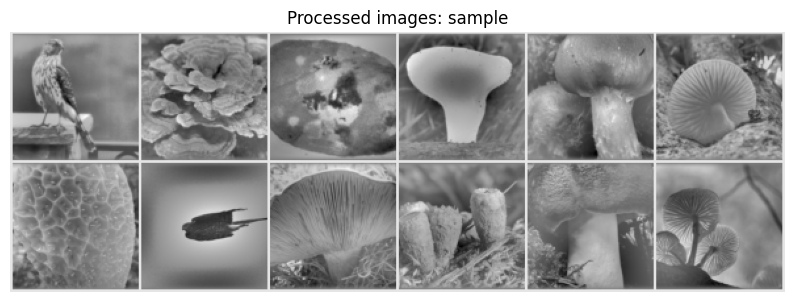

In [35]:
### 3.1. Load and preprocess images

import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Normalize, Compose, Resize, CenterCrop
import torch
from torch.utils.data import TensorDataset
from torchvision import utils as torch_utils
 
PATH_TO_DATA = '../../data/selection1866'

file_list = sorted(f for f in os.listdir(PATH_TO_DATA) if f.endswith('.mat'))
stim_ids = stimids.astype(int)

print(stim_ids)
print(stimids)

# TODO: run tile 1 and 2 through model separately + concat feature reps (no crop, pad)
transform = Compose([
    Resize(96), # Resize shortest edge to 96 (cut off the rightmost part of the image)
    CenterCrop((96, 96)), # Crop to (96, 96)
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # !! Normalize expects input is already in the range [0, 1]
])

img_tensors, labels = [], []

print('List:', file_list)

# we have 1866 images here, but the neural response data only uses 1573 of them
# because some ~300 images didn't have two repeats, so were disposed
# therefore we filter the full set here so that we only use the relevant 1573
for stim_id in stim_ids:
    filename = 'img' + str(stim_id) + '.mat'
    data = loadmat(os.path.join(PATH_TO_DATA, filename))

    img = data['img'][:, :500] # Take leftmost part of the image
    rgb_img = np.stack([img] * 3, axis=-1) # Convert grayscale to RGB for SimCLR
    tensor = torch.tensor(rgb_img, dtype=torch.float32).permute(2, 0, 1) # Shape (C, H, W)
    
    # Min-max scale the tensor to [0, 1]
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    tensor = (tensor - tensor_min) / (tensor_max - tensor_min)

    # Clamp to [0, 1] to ensure no outliers due to numerical precision
    tensor = torch.clamp(tensor, 0.0, 1.0)

    transformed_tensor = transform(tensor) # Normalize and resize for SimCLR
    img_tensors.append(transformed_tensor)
    labels.append(stim_id)

image_dataset = TensorDataset(torch.stack(img_tensors), torch.tensor(labels))

images, labels = image_dataset.tensors
print("Labels:", labels[:10])
print("Processed dataset shape:", images.shape) # (N, C, 96, 96)
print(f"Min pixel value (processed): {torch.min(images)}")
print(f"Max pixel value (processed): {torch.max(images)}")

# Show a sample of processed images
img_grid = torch_utils.make_grid(images[:12], nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0).numpy()
plt.figure(figsize=(10, 5))
plt.title('Processed images: sample')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [36]:
### 3.2. Run images through a pretrained SimCLR model and extract features

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torch.utils.data import Dataset
import urllib.request
from urllib.error import HTTPError

class SimCLR(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        # Base ResNet18 backbone (pretrained=False, because we load custom weights later, from the SimCLR checkpoint file)
        self.convnet = torchvision.models.resnet18(pretrained=False)
        
        # This is the projection head, only needed during training. For downstream tasks it is disposed of
        # and the final linear layer output is used (Chen et al., 2020) 
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)
        )

        self.activations = {}
        self.num_workers = os.cpu_count()
        self.device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
        self._register_hooks()

    def _register_hooks(self):
        """
        Register forward hooks to capture activations of convolutional layers.
        """
        def hook_fn(layer_name):
            def hook(module, input, output):
                if layer_name not in self.activations:
                    self.activations[layer_name] = []
                self.activations[layer_name].append(output.detach().cpu())
            return hook

        # Register hooks for all convolutional layers
        for name, layer in self.convnet.named_modules():
            if isinstance(layer, nn.Conv2d):
                layer.register_forward_hook(hook_fn(name))

    def load_pretrained(self):
        """
        Load pretrained SimCLR weights
        """
        base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
        models_dir = "../../models"
        pretrained_simclr_filename = "SimCLR.ckpt"
        pretrained_simclr_path = os.path.join(models_dir, pretrained_simclr_filename)
        os.makedirs(models_dir, exist_ok=True)

        # Check whether the pretrained model file already exists locally. If not, try downloading it
        file_url = base_url + pretrained_simclr_filename
        if not os.path.isfile(pretrained_simclr_path):
            print(f"Downloading pretrained SimCLR model {file_url}...")
            try:
                urllib.request.urlretrieve(file_url, pretrained_simclr_path)
            except HTTPError as e:
                print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

        print(f"Already downloaded pretrained model: {file_url}")

        # Load pretrained model
        checkpoint = torch.load(pretrained_simclr_path, map_location=self.device)
        self.load_state_dict(checkpoint['state_dict'])
        self.to(self.device)
        self.eval()
    
    def forward(self, x):
        """
        Forward pass of the model.
        """
        return self.convnet(x)

sim_clr = SimCLR()
sim_clr.load_pretrained()

data_loader = DataLoader(image_dataset, batch_size=64, shuffle=False, drop_last=False, num_workers=sim_clr.num_workers)
sim_clr.activations = {}

# Process images in batches
with torch.no_grad():
    for imgs, _ in data_loader:
        imgs = imgs.to(sim_clr.device)
        sim_clr(imgs) # Forward pass (hooks will collect activations)

# Convert list of activations to tensors
for layer_name in sim_clr.activations:
    sim_clr.activations[layer_name] = torch.cat(sim_clr.activations[layer_name], dim=0)

# Print stored activations
for layer_name, activation in sim_clr.activations.items():
    print(f"Layer: {layer_name}, Activation Shape: {activation.shape}")



Already downloaded pretrained model: https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/SimCLR.ckpt


/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/_c/21m3vmjd7c1_75f4nxmg1k480000gn/T/ipykernel_1267/77625971.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECUR

Layer: conv1, Activation Shape: torch.Size([1573, 64, 48, 48])
Layer: layer1.0.conv1, Activation Shape: torch.Size([1573, 64, 24, 24])
Layer: layer1.0.conv2, Activation Shape: torch.Size([1573, 64, 24, 24])
Layer: layer1.1.conv1, Activation Shape: torch.Size([1573, 64, 24, 24])
Layer: layer1.1.conv2, Activation Shape: torch.Size([1573, 64, 24, 24])
Layer: layer2.0.conv1, Activation Shape: torch.Size([1573, 128, 12, 12])
Layer: layer2.0.conv2, Activation Shape: torch.Size([1573, 128, 12, 12])
Layer: layer2.0.downsample.0, Activation Shape: torch.Size([1573, 128, 12, 12])
Layer: layer2.1.conv1, Activation Shape: torch.Size([1573, 128, 12, 12])
Layer: layer2.1.conv2, Activation Shape: torch.Size([1573, 128, 12, 12])
Layer: layer3.0.conv1, Activation Shape: torch.Size([1573, 256, 6, 6])
Layer: layer3.0.conv2, Activation Shape: torch.Size([1573, 256, 6, 6])
Layer: layer3.0.downsample.0, Activation Shape: torch.Size([1573, 256, 6, 6])
Layer: layer3.1.conv1, Activation Shape: torch.Size([1573

In [61]:
from sklearn.decomposition import PCA
import numpy as np

# Our original images are grayscale, but SimCLR expects 3-channel RGB input.
# To meet this requirement, we duplicated the grayscale values across all three RGB channels.
# However, for PCA, we only need a single channel, so we extract just the first channel (Red).
raw_pixels_flat = images[:, 0, :, :].view(images.shape[0], -1)

print(images.shape) # torch.Size([1573, 3, 96, 96])
print(raw_pixels_flat.shape) # torch.Size([1573, 9216]) - (1573, 1*96*96)

num_pcs = 100 

pca = PCA(n_components=num_pcs)
pca.fit(raw_pixels_flat)
raw_pixels_ev = pca.explained_variance_ratio_
raw_pixels_cev = np.cumsum(raw_pixels_ev)
raw_pixels_features = pca.transform(raw_pixels_flat.numpy())

torch.Size([1573, 3, 96, 96])
torch.Size([1573, 9216])


dict_keys(['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.0.downsample.0', 'layer2.1.conv1', 'layer2.1.conv2', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.0.downsample.0', 'layer3.1.conv1', 'layer3.1.conv2', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.0.downsample.0', 'layer4.1.conv1', 'layer4.1.conv2'])
torch.Size([1573, 512, 3, 3])
(1573, 4608)
torch.Size([1573, 64, 24, 24])
(1573, 36864)


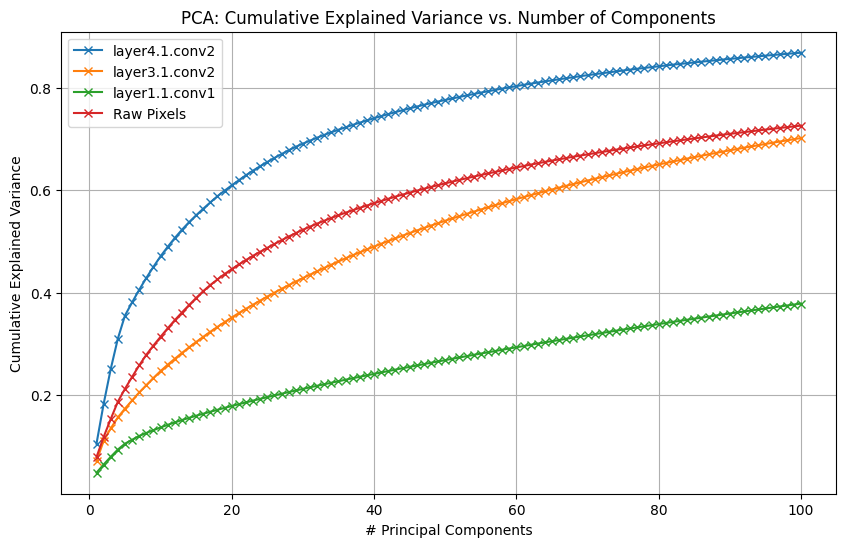

In [70]:
from sklearn.decomposition import PCA
import numpy as np

# dict_keys(['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.0.downsample.0', 'layer2.1.conv1', 'layer2.1.conv2', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.0.downsample.0', 'layer3.1.conv1', 'layer3.1.conv2', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.0.downsample.0', 'layer4.1.conv1', 'layer4.1.conv2'])
print(sim_clr.activations.keys())

# layer4.1.conv2
l4conv2_activations = sim_clr.activations['layer4.1.conv2']
N, C, H, W = l4conv2_activations.shape
l4conv2_activations_flat = l4conv2_activations.view(N, -1).numpy() # Shape: (N, C*H*W)

print(l4conv2_activations.shape) # torch.Size([1573, 512, 3, 3])
print(l4conv2_activations_flat.shape) # (1573, 4608)

pca_l4conv2 = PCA(n_components=num_pcs)
pca_l4conv2.fit(l4conv2_activations_flat)
l4conv2_ev = pca_l4conv2.explained_variance_ratio_
l4conv2_cev = np.cumsum(l4conv2_ev)
l4conv2_features = pca_l4conv2.transform(l4conv2_activations_flat)

# layer1.1.conv1
l1conv1_activations = sim_clr.activations['layer1.1.conv1']
N, C, H, W = l1conv1_activations.shape
l1conv1_activations_flat = l1conv1_activations.view(N, -1).numpy() # Shape: (N, C*H*W)

print(l1conv1_activations.shape)
print(l1conv1_activations_flat.shape)

pca_l1conv1 = PCA(n_components=num_pcs)
pca_l1conv1.fit(l1conv1_activations_flat)
l1conv1_ev = pca_l1conv1.explained_variance_ratio_
l1conv1_cev = np.cumsum(l1conv1_ev)
l1conv1_features = pca_l1conv1.transform(l1conv1_activations_flat)

# layer3.1.conv1
l3conv1_activations = sim_clr.activations['layer3.1.conv1']
N, C, H, W = l3conv1_activations.shape
l3conv1_activations_flat = l3conv1_activations.view(N, -1).numpy() # Shape: (N, C*H*W)

pca_l3conv1 = PCA(n_components=num_pcs)
pca_l3conv1.fit(l3conv1_activations_flat)
l3conv1_ev = pca_l3conv1.explained_variance_ratio_
l3conv1_cev = np.cumsum(l3conv1_ev)
l3conv1_features = pca_l3conv1.transform(l3conv1_activations_flat)

# Plot PCA for comparison
plot_components = range(1, num_pcs + 1)
plt.figure(figsize=(10, 6))
plt.plot(plot_components, l4conv2_cev, label="layer4.1.conv2", marker='x')
plt.plot(plot_components, l3conv1_cev, label="layer3.1.conv2", marker='x')
plt.plot(plot_components, l1conv1_cev, label="layer1.1.conv1", marker='x')
plt.plot(plot_components, raw_pixels_cev, label="Raw Pixels", marker='x')
plt.xlabel("# Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Cumulative Explained Variance vs. Number of Components")
plt.legend()
plt.grid(True)
plt.show()

In [76]:
### Run regression

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(l3conv1_activations_flat, neural_responses_mean, test_size=0.2, random_state=42)

# Train Ridge regression (per neuron)
reg = Ridge(alpha=1.0) # Adjust alpha for regularization
reg.fit(X_train, Y_train)

# Predict
Y_pred = reg.predict(X_test)

# Evaluate
r2_scores = r2_score(Y_test, Y_pred, multioutput='raw_values')
print(r2_scores)

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.25434e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


[-1.65537971 -2.34466383 -1.74534292 ... -1.58796643 -1.34484745
 -1.74064   ]


In [77]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500)
mlp.fit(X_train, Y_train)
Y_pred_mlp = mlp.predict(X_test)

r2_scores_mlp = r2_score(Y_test, Y_pred_mlp, multioutput='raw_values')
print("R² using MLP:", r2_scores_mlp)

R² using MLP: [-0.01268875 -0.00311259 -0.00299889 ... -0.01067688 -0.00514262
 -0.00811641]


In [ ]:
l3conv1_activations = sim_clr.activations['layer3.1.conv1']
N, C, H, W = l3conv1_activations.shape
l3conv1_activations_flat = l3conv1_activations.view(N, -1).numpy() # Shape: (N, C*H*W)

num_components = 2  # Try 50, 100, 200
pca = PCA(n_components=num_components)
layer4_pca = pca.fit_transform(l3conv1_activations_flat)

X_train, X_test, Y_train, Y_test = train_test_split(layer4_pca, neural_responses_mean, test_size=0.2, random_state=42)

reg.fit(X_train, Y_train)
r2_scores_pca = r2_score(Y_test, reg.predict(X_test), multioutput='raw_values')

print(f"R² using {num_components} PCs:", r2_scores_pca)

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.25434e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


R² using 1 PCs: [-1.65537971 -2.34466383 -1.74534292 ... -1.58796643 -1.34484745
 -1.74064   ]
